\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

In [2]:
!pip install pmdarima > /dev/null

In [63]:
from pmdarima.model_selection import train_test_split
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pmdarima as pm
import numpy as np

ticker = '^gspc'
start = '2020-01-01'
end = '2021-04-16'
shf = 1

adjclose = pdr.get_data_yahoo(ticker, start, end)['Adj Close']
logret = np.log(adjclose/adjclose.shift(shf)).dropna()

smt.stattools.adfuller(logret)

(-4.727019298706826,
 7.48488347166799e-05,
 8,
 315,
 {'1%': -3.451281394993741,
  '5%': -2.8707595072926293,
  '10%': -2.571682118921643},
 -1593.4382263462237)

In [34]:
import warnings
warnings.filterwarnings('ignore')

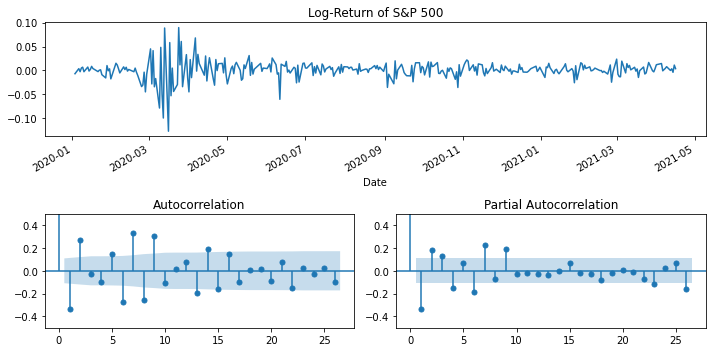

In [35]:
from statsmodels.tsa.arima_model import ARMA
from pandas import Series
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

def tsplot(ts, title, acf_ylim=(-0.2, 0.2)):
    fig = plt.figure(figsize=(10, 5))
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    pacf_ax = plt.subplot2grid(layout, (1,1))
    acf_ax = plt.subplot2grid(layout, (1,0))

    Series(ts).plot(ax=ts_ax)
    smt.graphics.plot_acf(ts, ax=acf_ax)
    smt.graphics.plot_pacf(ts, ax=pacf_ax)
    ts_ax.set(title=title)
    pacf_ax.set(ylim=acf_ylim)
    acf_ax.set(ylim=acf_ylim)

    plt.tight_layout()
    plt.show()
    
tsplot(logret, title='Log-Return of S&P 500', acf_ylim=(-0.5, 0.5))

In [37]:
# from statsmodels.stats.diagnostic import acorr_ljungbox
# acorr_ljungbox(logret, return_df=True)

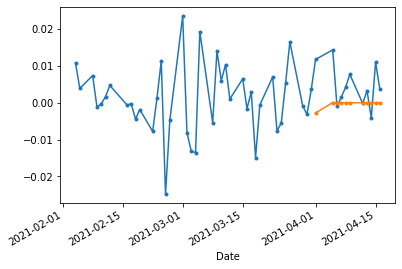

In [29]:
from pandas import Series

test_size = 11

train, test = train_test_split(logret, test_size=test_size)
model = pm.auto_arima(train, seasonal=False)
# model.summary()

forecasts = Series(model.predict(test_size), index=logret.tail(test_size).index)

ax = logret.tail(50).plot(style='.-')
forecasts.plot(ax=ax, style='.-')
pass

# 2. {-}

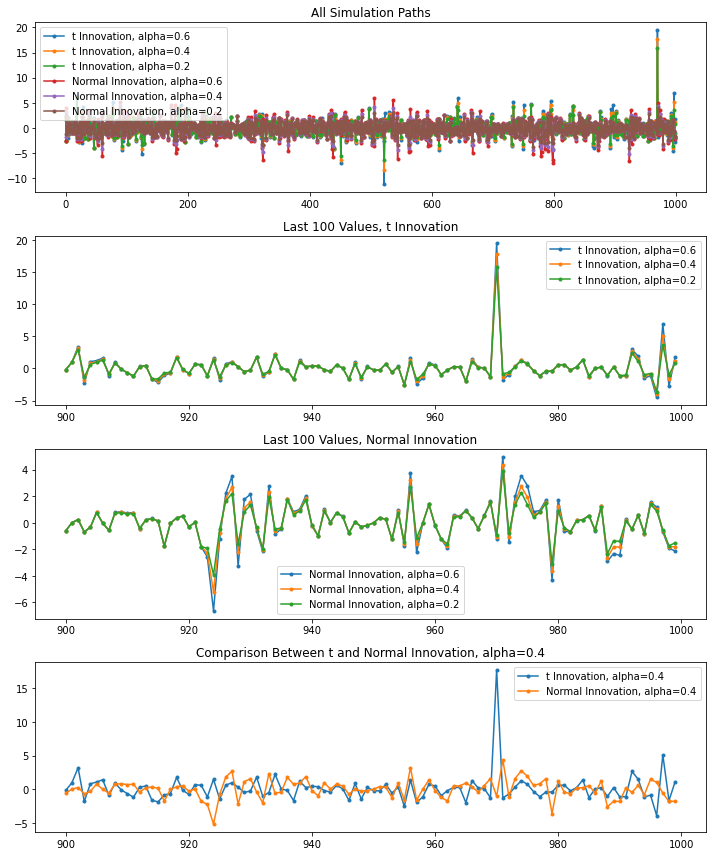

In [1]:
from pandas import DataFrame
from arch.univariate import GARCH, Normal
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import numpy as np
import numpy.random

seed = 3
alphas = [.6, .4, .2]
paths = {}

# t innovation
for alpha in alphas:
    numpy.random.seed(seed)
    model = GARCH(1, 0, 0)
    y, variance = model.simulate([1, alpha], 1000, rng=lambda size: t.rvs(df=4, size=size)/np.sqrt(2))
    paths[f't Innovation, alpha={alpha}'] = y

# normal innovation
for alpha in alphas:
    numpy.random.seed(seed)
    model = GARCH(1, 0, 0)
    y, variance = model.simulate([1, alpha], 1000, rng=lambda size: norm.rvs(size=size))
    paths[f'Normal Innovation, alpha={alpha}'] = y
    
df = DataFrame(paths)    
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

df.plot(style='.-', ax=ax1, title='All Simulation Paths')
df[[col for col in df.columns if 't Innov' in col]].iloc[-100:, :].plot(style='.-', ax=ax2, title='Last 100 Values, t Innovation')
df[[col for col in df.columns if 'Normal Innov' in col]].iloc[-100:, :].plot(style='.-', ax=ax3, title='Last 100 Values, Normal Innovation')
df[[col for col in df.columns if '.4' in col]].iloc[-100:, :].plot(style='.-', ax=ax4, title='Comparison Between t and Normal Innovation, alpha=0.4')
plt.tight_layout()
plt.show()

# 3. {-}

## (a) {-}
Since $E[\epsilon_t] = 0$, we have
\begin{align*}
E[Y_t] &= E\left[1 + 0.6Y_{t-1} + \epsilon_t\sqrt{1.5 + 0.3 a_{t-1}^2}\right]\\
        &= 1 + 0.6E[Y_{t-1}] + E[\epsilon_t]E\left[\sqrt{1.5 + 0.3 a_{t-1}^2}\right] = 1 + 0.6E[Y_{t-1}]. 
\end{align*}
Assuming $Y_t$ is stationary, its mean must be constant and we have $E[Y_t] = 1 + 0.6E[Y_{t}]$, which solves to $E[Y_t] = 1/0.4 = 2.5$.

## (b) {-}
First note that $E[a_t] = 0$ and 
\begin{align*}
E[a_t^2] &= E[1.5\epsilon_t^2 + 0.3a_{t-1}^2] = 1.5 + 0.3E[a_{t-1}^2].
\end{align*}
Assuming $a_t^2$ is stationary, its mean must be constant, so $E[a_t^2] = 1.5 + 0.3E[a_{t}^2]$ which solves to $E[a_{t}^2] = 1.5/0.7 = 2.142857$.


To find the (unconditional) variance of $Y_t$, first write
\begin{align*}
E[Y_t^2] &= E[(1 + 0.6Y_{t-1} + a_t)^2]\\
        &= E[1 + 1.2Y_{t-1} + 2a_t + 0.36Y_{t-1}^2 + 1.2a_tY_{t-1} + a_t^2]\\
        &= 1 + 1.2E[Y_{t-1}] + 2E[a_t] + 0.36E[Y_{t-1}^2] + E[1.2a_tY_{t-1}] + 2.142857\\
        &= 1 + 1.2(2.5) + 0.36E[Y_{t-1}^2] + E[1.2a_tY_{t-1}] + 2.142857\\
        &= 1 + 1.2(2.5) + 0.36E[Y_{t-1}^2] + 2.142857\\
        &= 0.36E[Y_{t-1}^2] + 6.142857.
\end{align*}
Here the cross term $E[1.2a_tY_{t-1}]$ is zero because $E[\epsilon_t] = 0$ and
\begin{align*}
E[a_tY_{t-1}] = E\left[\epsilon_t\sqrt{1.5 + 0.3 a_{t-1}^2}Y_{t-1}\right] = E[\epsilon_t]E\left[\sqrt{1.5 + 0.3 a_{t-1}^2}Y_{t-1}\right] = 0.
\end{align*}
Again assuming $Y_t$ is stationary, we must have $E[Y_{t-1}^2] = E[Y_{t}^2]$ and hence
\begin{align*}
E[Y_t^2] = 0.36E[Y_{t}^2] + 6.142857, 
\end{align*}
which solves to $E[Y_t^2] = 6.142857/0.64 = 9.5982$.
Thus we have the variance
\begin{align*}
V(Y_t) = E[Y_t^2] - E[Y_t]^2 = 9.5982 - 2.5^2 = 3.3482.
\end{align*}


## (c) {-}
For $h\neq 0$, we have 
\begin{align*}
E[Y_t Y_{t-h}] &= E[(1 + 0.6Y_{t-1} + a_t)(1 + 0.6Y_{t-1-h} + a_{t-h})]\\
&= E[1 + 0.6Y_{t-1-h} + a_{t-h} + 0.6Y_{t-1} + 0.36Y_{t-1}Y_{t-1-h} + 0.6Y_{t-1}a_{t-h} + a_t + 0.6a_tY_{t-1-h} + a_ta_{t-h}]
\end{align*}


\begin{align*}
\gamma_Y(h) = \frac{E[Y_t Y_{t-h}] - E[Y_t]E[Y_{t-h}]}{\sqrt{V(Y_t)V(Y_{t-h})}}.
\end{align*}


## (d) {-}
For $h\neq 0$, we have 
\begin{align*}
E[a_t a_{t-h}] &= E\left[\epsilon_t\epsilon_{t-h}\sqrt{1.5 + 0.3 a_{t-1}^2}\sqrt{1.5 + 0.3 a_{t-1-h}^2}\right]\\
&= E[\epsilon_t]E\left[\epsilon_{t-h}\sqrt{1.5 + 0.3 a_{t-1}^2}\sqrt{1.5 + 0.3 a_{t-1-h}^2}\right] = 0.
\end{align*}
Thus the autocorrelation function is 
\begin{align*}
\gamma_a(h) = \frac{E[a_t a_{t-h}] - E[a_t]E[a_{t-h}]}{\sqrt{V(a_t)V(a_{t-h})}} = 0.
\end{align*}




# 4. {-}

In [66]:
from arch.univariate import ConstantMean, GARCH, Normal

am = ConstantMean(100*logret)
am.volatility = GARCH(1, 0, 1)
am.distribution = Normal()
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2291.311999654301
Iteration:      2,   Func. Count:     15,   Neg. LLF: 28712242094.884525
Iteration:      3,   Func. Count:     23,   Neg. LLF: 962.6498779592871
Iteration:      4,   Func. Count:     30,   Neg. LLF: 656.6014480333913
Iteration:      5,   Func. Count:     36,   Neg. LLF: 550.0892100324096
Iteration:      6,   Func. Count:     42,   Neg. LLF: 549.6501599785147
Iteration:      7,   Func. Count:     47,   Neg. LLF: 549.6438746115897
Iteration:      8,   Func. Count:     52,   Neg. LLF: 549.6428412723499
Iteration:      9,   Func. Count:     57,   Neg. LLF: 549.6426821896139
Iteration:     10,   Func. Count:     62,   Neg. LLF: 549.6426759504059
Iteration:     11,   Func. Count:     66,   Neg. LLF: 549.6426759504911
Optimization terminated successfully    (Exit mode 0)
            Current function value: 549.6426759504059
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 1

In [67]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -549.643
Distribution:                  Normal   AIC:                           1107.29
Method:            Maximum Likelihood   BIC:                           1122.41
                                        No. Observations:                  324
Date:                Tue, Apr 20 2021   Df Residuals:                      323
Time:                        14:41:25   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1442  5.869e-02      2.456  1.404e-02 [2.913e-02,  0.259]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1479  5.878e-02      2.516  1.187e-02 [3.268e-02,  0.263]
alpha[1]       0.3148  9.572e-02      3.289  1.007e-03   [  0.127,  0.502]
beta[1]        0.6536  7.116e-02      9.185  4.122e-20   [  0.514,  0.793]
==========================================================================

Covariance estimator: robust
"""